In [3]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
import numpy as np
import pickle as pkl

# Hierarchical Clustering Example: Human Tumor Microarray Data

In [4]:
# Import micro-array data
f = open('nci.micro.data.pkl', 'rb')
data_dic = pkl.load(f)
f.close()

X = data_dic['data'].T
y = data_dic['labels']

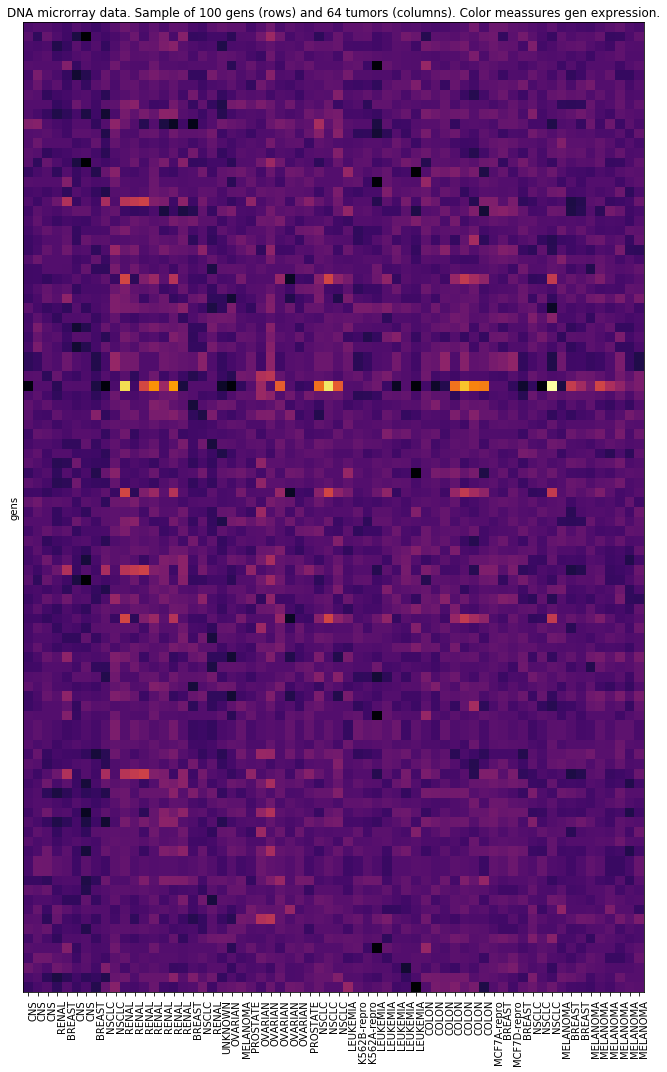

In [34]:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(X.T[np.random.randint(len(X), size=100),:], cmap='inferno')

labels = data_dic['labels']
gens = [f'gen{x:03}' for x in range(100)]

# We want to show all ticks
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks([])
ax.set_xticklabels(labels)
ax.set_ylabel('gens')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

ax.set_title("DNA microrray data. Sample of 100 gens (rows) and 64 tumors (columns). Color meassures gen expression.")
fig.tight_layout()
plt.show()

## Base Model: K-means

In [24]:
from sklearn.cluster import KMeans

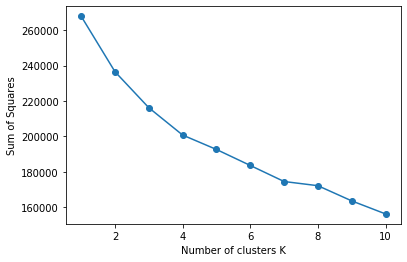

In [35]:
# How many clusters?
sum_sq = []
for K in range(1,11):
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
    sum_sq.append(kmeans.inertia_)
plt.plot(range(1,11), sum_sq, '-o')
plt.xlabel('Number of clusters K')
plt.ylabel('Sum of Squares');

In [65]:
# No clear elbow, choose K=3.
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
C = kmeans.labels_

In [69]:
# Build table with label count
import pandas as pd

y = np.array(y)
labels = np.unique(y)
l_counts = []
for k in range(3):
    k_counts = []
    y_k = y[C==k]
    for label in labels:
        k_counts.append(len(y_k[y_k == label]))
    l_counts.append(k_counts)

df = pd.DataFrame(data=l_counts, columns=labels)
df

,BREAST,CNS,COLON,K562A-repro,K562B-repro,LEUKEMIA,MCF7A-repro,MCF7D-repro,MELANOMA,NSCLC,OVARIAN,PROSTATE,RENAL,UNKNOWN
0,2,0,7,1,1,6,1,1,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,7,0,0,0,0,0
2,3,5,0,0,0,0,0,0,1,9,6,2,9,1


We see that the procedure is successful at grouping together samples of the same cancer. In fact, the two breast cancers in the second cluster were later found to be misdiagnosed and were melanomas that had metastasized. However, K-means clustering has shortcomings in this application. For one, it does not give a linear ordering of objects within a cluster. Secondly, as the number of clusters K is changed, the cluster membership can change in arbitrary ways. That is, with say four clusters, the clusters need not to be nested with the three clusters above. For these reason, hierarchical clustering is probably preferable for this application.

## Agglomerative clustering

In [34]:
# We'll try different linkage methods and compare them side by side.

# Single linkage
Z_sl = linkage(X, 'single', optimal_ordering='True')

# Complete linkage
Z_cl = linkage(X, 'complete', optimal_ordering='True')

# Average linkage
Z_al = linkage(X, 'average', optimal_ordering='True')

# Ward linkage
Z_ward = linkage(X, 'ward', optimal_ordering='True')

What is $Z$? $Z$ is the **linkage matrix**. Each row of $Z$ tells us what clusters are merged in each of the $N-1$ iterations of the algorithm. Each row is composed of

[$cluster_i$, $cluster_j$, $d_{ij}$, Observation in new cluster ]


In [13]:
Z_sl[0]

array([50.        , 49.        , 38.23033267,  2.        ])

So, at the first iteration, observations 50 and 49 are merged into a cluster of 2 elements. The single linkage distance of these observations in 38.23.

In [14]:
Z_sl[20]

array([10.        , 81.        , 63.57607597,  7.        ])

On iteration 21, clusters 10 (original obs) and cluster 81 are merged. Note that we had 64 original samples, so the index 81 must refer to a new cluster created in a previous step. Let's print a couple of rows. Specifically, all indices greater than `len(X)` refer to the cluster formed in step `idx - len(X)`, so index 81 refers to the cluster created in step $81-64 = 17$. Also note that the distance increases monotonically with each step, which allows the interpretation of branch lengths in the dendogram.

In [20]:
Z_sl[:20]

array([[50.        , 49.        , 38.23033267,  2.        ],
       [48.        , 64.        , 38.59604166,  3.        ],
       [56.        , 57.        , 39.10562479,  2.        ],
       [20.        , 21.        , 45.15158096,  2.        ],
       [34.        , 35.        , 45.35338129,  2.        ],
       [68.        , 36.        , 45.44295228,  3.        ],
       [ 1.        ,  0.        , 51.43823073,  2.        ],
       [61.        , 60.        , 56.78015373,  2.        ],
       [71.        , 59.        , 56.96831087,  3.        ],
       [11.        , 12.        , 57.91726379,  2.        ],
       [73.        , 13.        , 60.35052271,  3.        ],
       [41.        , 43.        , 60.49650657,  2.        ],
       [16.        , 74.        , 60.804411  ,  4.        ],
       [38.        , 39.        , 61.55425326,  2.        ],
       [30.        , 31.        , 61.63750362,  2.        ],
       [75.        , 45.        , 61.9292807 ,  3.        ],
       [15.        , 14.

Another thing you can do is calculate the [Cophenetic Correlation Coefficient](https://en.wikipedia.org/wiki/Cophenetic_correlation) of your hierarchy- This correlates the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances.

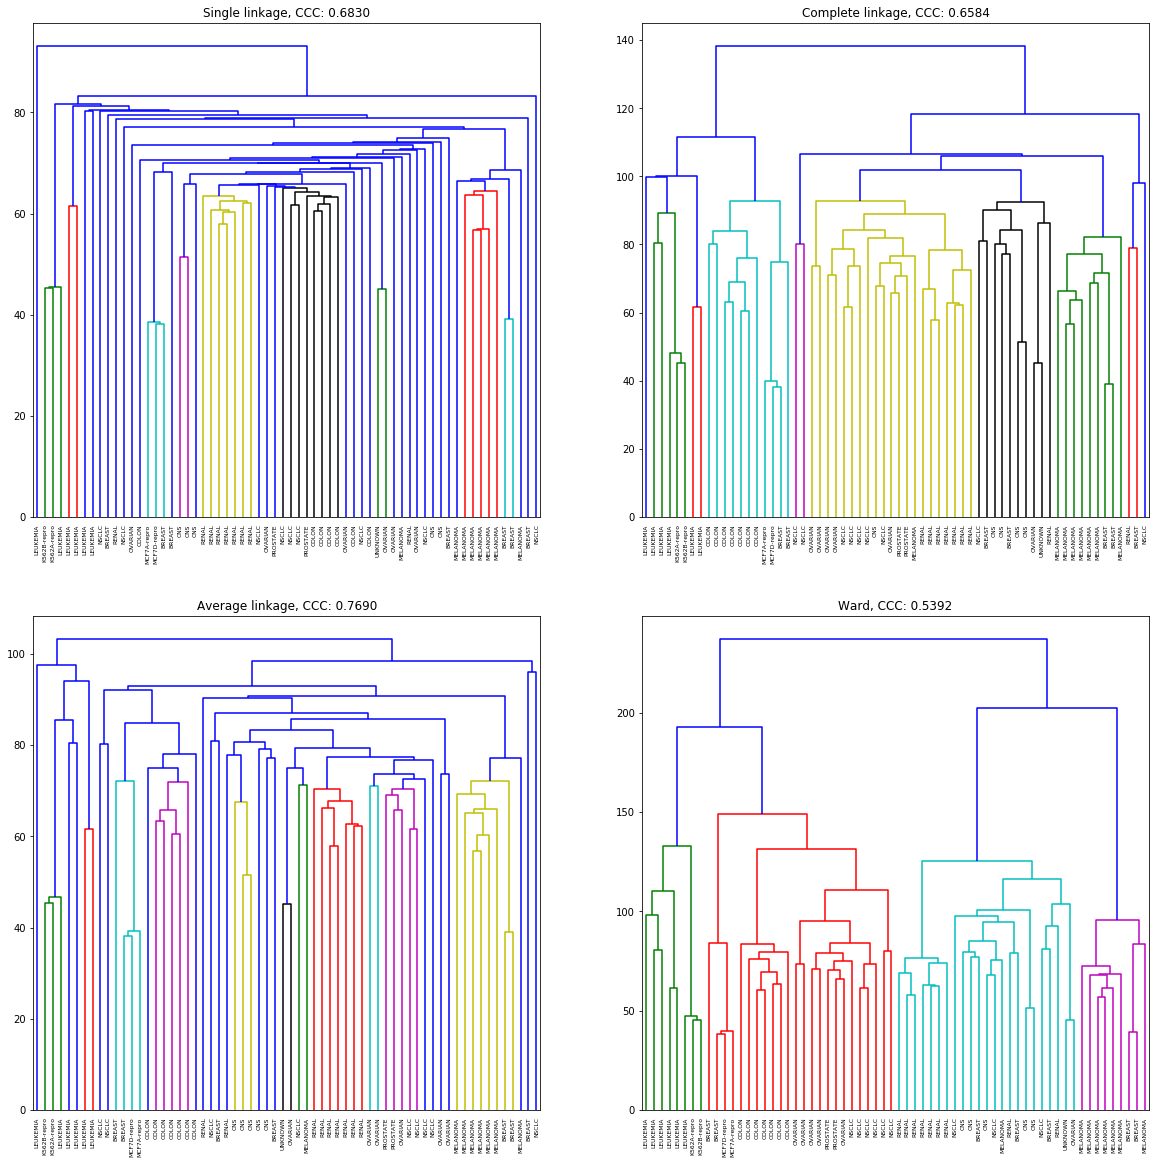

In [46]:
# Now, lets visualize the dendograms

# Condensed distance matrix:
D = pdist(X)

fig, ax = plt.subplots(2,2, figsize=(20,20))
ax[0,0].set_title(f'Single linkage, CCC: {cophenet(Z_sl, D)[0]:0.4f}')
dendrogram(Z_sl, ax=ax[0,0], labels=y);

ax[0,1].set_title(f'Complete linkage, CCC: {cophenet(Z_cl, D)[0]:0.4f}')
dendrogram(Z_cl, ax=ax[0,1], labels=y);

ax[1,0].set_title(f'Average linkage, CCC: {cophenet(Z_al, D)[0]:0.4f}')
dendrogram(Z_al, ax=ax[1,0], labels=y);

ax[1,1].set_title(f'Ward, CCC: {cophenet(Z_ward, D)[0]:0.4f}')
dendrogram(Z_ward, ax=ax[1,1], labels=y);

Average and complete linkage gave similar results, while single
linkage produced unbalanced groups with long thin clusters. We focus on
the average linkage clustering, which reports the largest Cophenetic Correlation Coefficient.

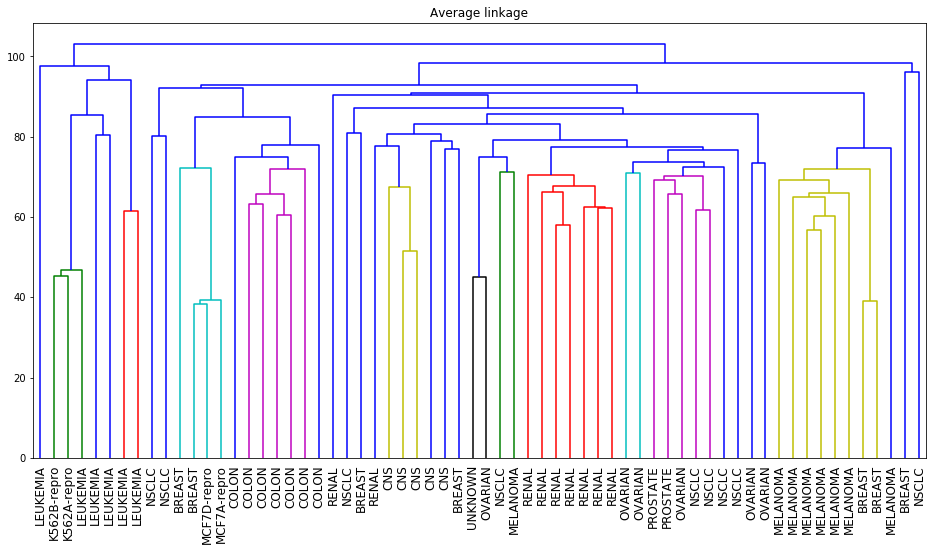

In [49]:
fig = plt.figure(figsize=(16,8))
dendrogram(Z_al, labels=y, leaf_font_size=12);
plt.title('Average linkage');

Like K-means clustering, hierarchical clustering is successful at clustering
simple cancers together. However it has other nice features. By cutting off
the dendrogram at various heights, different numbers of clusters emerge,
and the sets of clusters are nested within one another. Secondly, it gives
some partial ordering information about the samples.

We can cut the dendrogram at some height to obtain a specific partition. The choice of the number of clusters $k$ is still ill-defined. Techniques useful with K-means, such as the elbow method or the gap statistic, can be used here as well, but expert knowledge is still often required to find a meaningful partition.

We can use the `fcluster` function to specify the cut on the tree in several ways (look at the documentation).

In [54]:
from scipy.cluster.hierarchy import fcluster

# Specifying the distance at which to cut
labels_1 = fcluster(Z_al, 90, criterion='distance')
print(labels_1)

# Specifying the number of cluster
labels_2 = fcluster(Z_al, 3, criterion='maxclust')
print(labels_2)

[ 6  6  6  6  9  6  6  6  6 10  6  6  6  6  6  6  6  6  6  7  6  6  6  6
  6  6  6  6  6  6  6  6  6  1  1  1  1  1  2  2  3  5  5  5  5  5  5  5
  5  5  5  5  6  4  4  8  8  8  8  8  8  8  8  8]
[2 2 2 2 3 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


We can apply clustering to both rows and columns for a nice visualization.

In [ ]:
# Perform clustering on rows
Z_rows = linkage(X.T, 'average', optimal_ordering='True')

[]

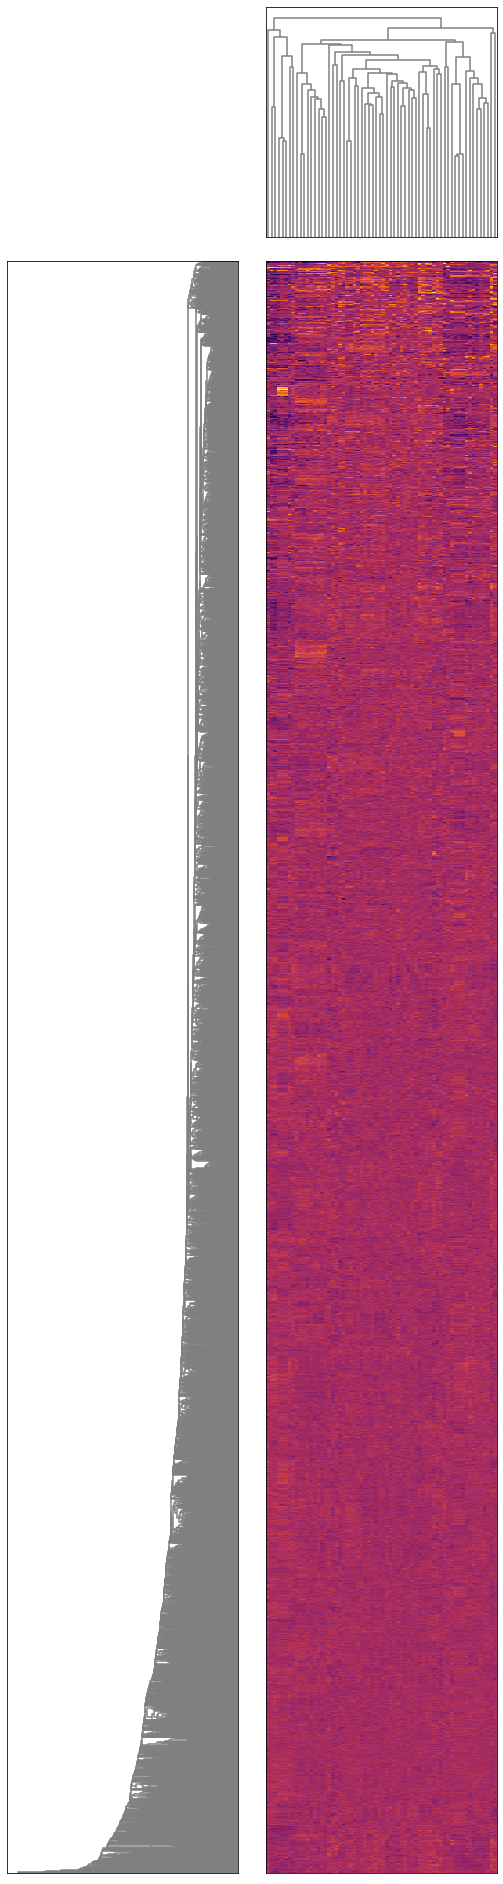

In [106]:
# Compute and plot first dendrogram.
fig = plt.figure(figsize=(8,32))
# x ywidth height
ax1 = fig.add_axes([0.05,0.1,0.4,0.7])
D1 = dendrogram(Z_rows, orientation='left', distance_sort=True, color_threshold=0, link_color_func=lambda k: 'grey')
ax1.set_yticks([])
ax1.set_xticks([])

#Compute and plot second dendrogram.
ax2 = fig.add_axes([0.5,0.81,0.4,0.1])
D2 = dendrogram(Z_al, orientation='top', distance_sort=True, color_threshold=0, link_color_func=lambda k: 'grey')
ax2.set_yticks([])
ax2.set_xticks([])

#Compute and plot the heatmap
ax3 = fig.add_axes([0.5,0.1,0.4,0.7])
im = ax3.imshow(X[D2['leaves']].T[D1['leaves']], cmap='inferno', aspect='auto')
ax3.set_yticks([])
ax3.set_xticks([])

## References
- Elements of Statistical Learning Section 14.3.12

**Note**: There exists a far superior implementation in terms of memory usage called `fastcluster` useful for large datasets. Learn more about the fastcluster module http://danifold.net/fastcluster.html